In [ ]:
!pip install numpy==1.21.5
!pip install keras==2.7.0
!pip install tensorflow==2.7.0
!pip install matplotlib==3.5.1

In [1]:
# Importing libraries
import numpy as np
import pathlib
from tensorflow import keras
from tensorflow.keras import layers
import PIL
import tensorflow as tf
from tensorflow.keras.models import Sequential

---

In [2]:
# Directory path to the training data
data_dir = pathlib.Path("input/Training_data/")


In [3]:
# Count the total number of image files within the "input/Training_data/" directory and its subdirectories
image_count = len(list(data_dir.glob('*/*')))

print(image_count)


600


In [4]:
# List of file paths for the 'driving_license' category
driving_license = list(data_dir.glob('driving_license/*'))

# List of file paths for the 'social_security' category
social_security = list(data_dir.glob('social_security/*'))

# List of file paths for the 'others' category
others = list(data_dir.glob('others/*'))


In [5]:
# Open an image using PIL
image = PIL.Image.open(str(driving_license[2]))


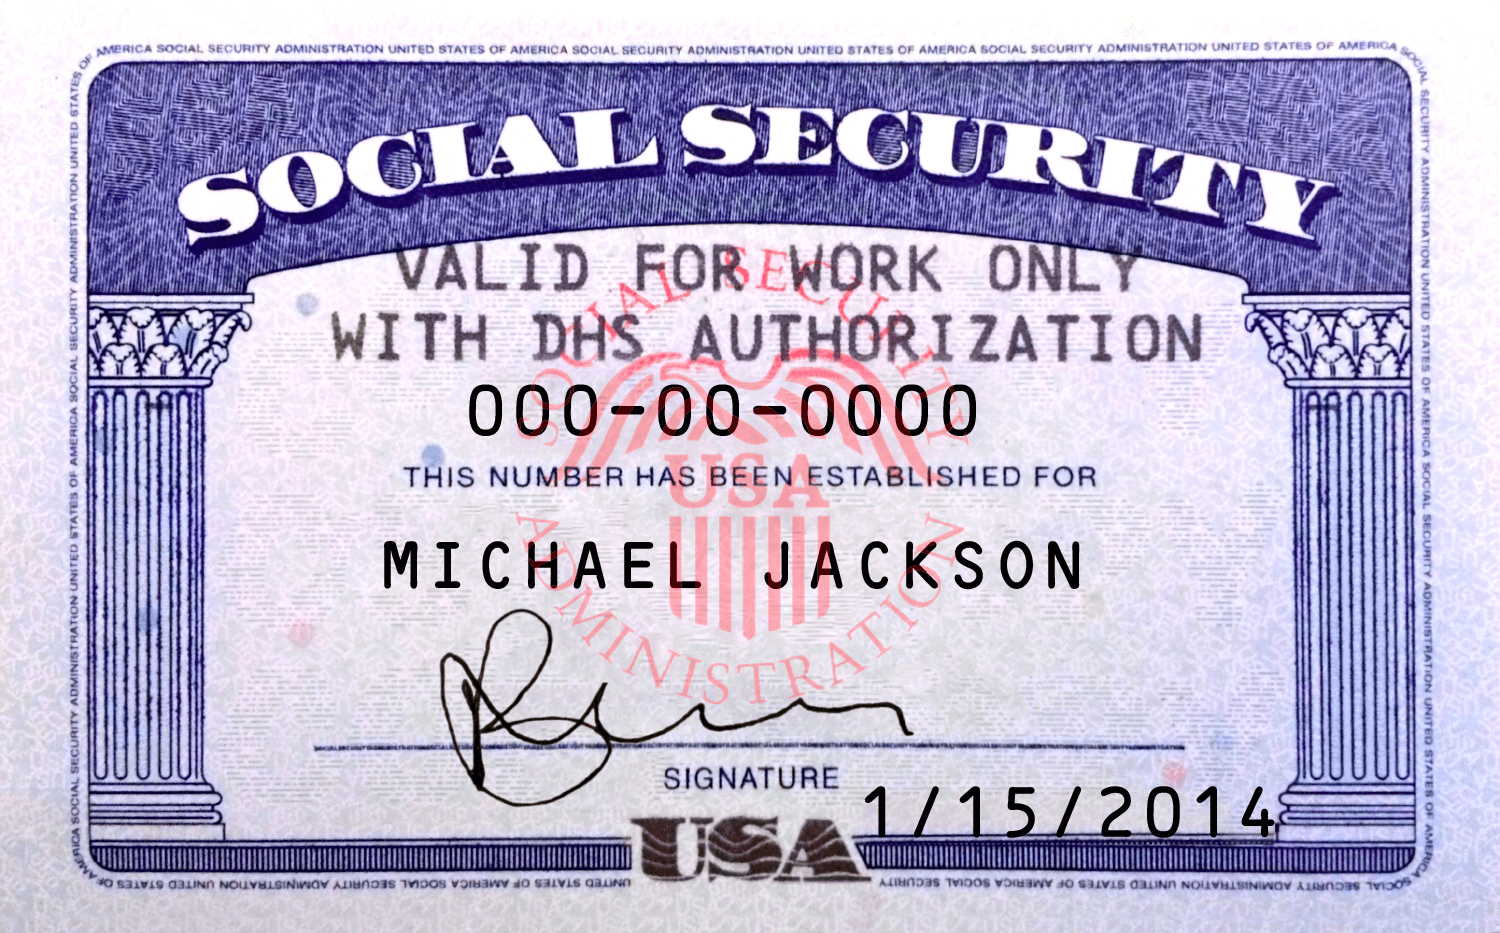

In [6]:
# Open an image using PIL
PIL.Image.open(str(social_security[10]))

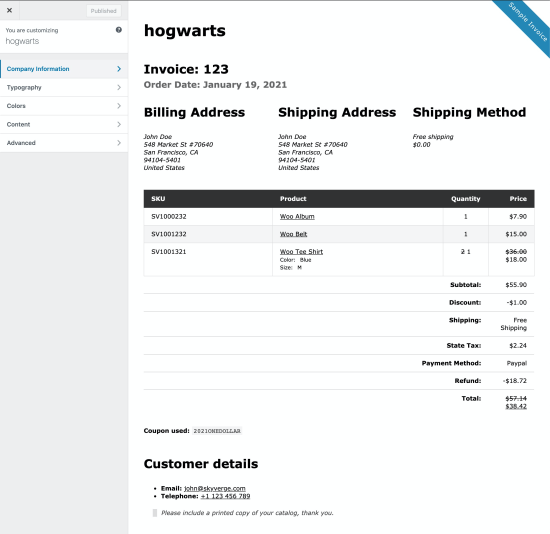

In [9]:
# Open an image using PIL
PIL.Image.open(str(others[140]))

In [7]:
batch_size = 32
img_height = 180
img_width = 180

In [8]:
# Create a training dataset using TensorFlow's image_dataset_from_directory function
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,                  # The directory containing the image data
    validation_split=0.2,      # Split 20% of the data for validation
    subset="training",         # Use the subset "training" for the training dataset
    seed=123,                  # Set the random seed to ensure data consistency
    image_size=(img_height, img_width),  # Resize images to the specified dimensions
    batch_size=batch_size      # Use a batch size of 'batch_size' for the training dataset
)


Found 600 files belonging to 3 classes.
Using 480 files for training.


2024-11-03 23:57:51.932860: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
# Create a validation dataset using TensorFlow's image_dataset_from_directory function
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,                  # The directory containing the image data
    validation_split=0.2,      # Split 20% of the data for validation
    subset="validation",       # Use the subset "validation" for the validation dataset
    seed=123,                  # Set the random seed to ensure data consistency
    image_size=(img_height, img_width),  # Resize images to the specified dimensions
    batch_size=batch_size      # Use a batch size of 'batch_size' for the validation dataset
)


Found 600 files belonging to 3 classes.
Using 120 files for validation.


In [10]:
# Displaying classes
class_names = train_ds.class_names
print(class_names)

['driving_license', 'others', 'social_security']


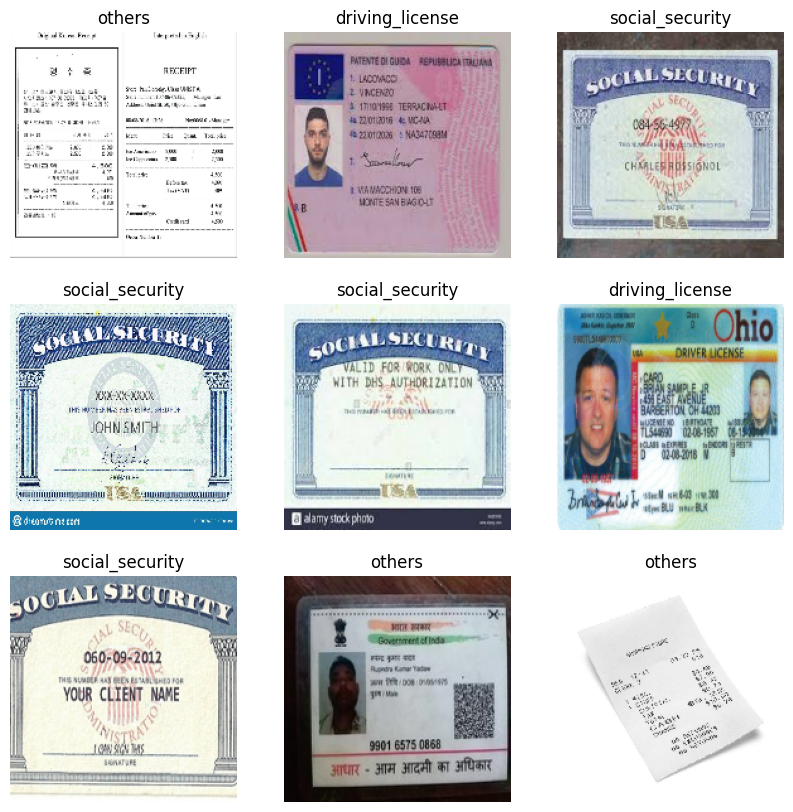

In [12]:
import matplotlib.pyplot as plt

# Create a new figure with a specified size
plt.figure(figsize=(10, 10))

# Loop through the first batch of images and labels in the training dataset
for images, labels in train_ds.take(1):
    # Iterate through the first 9 images in the batch
    for i in range(9):
        # Create a subplot within the 3x3 grid
        ax = plt.subplot(3, 3, i + 1)
        
        # Display the image as a plot and convert it to uint8 format
        plt.imshow(images[i].numpy().astype("uint8"))
        
        # Set the title of the subplot to the corresponding class name
        plt.title(class_names[labels[i]])
        
        # Turn off the axis to remove axis labels
        plt.axis("off")


plt.show()


In [13]:
# Loop through batches of images and labels in the training dataset

for image_batch, labels_batch in train_ds:
    # Print the shape of the current image batch
    print(image_batch.shape)

    # Print the shape of the current label batch
    print(labels_batch.shape)

    break


(32, 180, 180, 3)
(32,)


In [14]:
# Define AUTOTUNE to utilize TensorFlow's automatic optimization
AUTOTUNE = tf.data.AUTOTUNE

# Cache, shuffle, and prefetch the training dataset for improved performance
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

# Cache and prefetch the validation dataset for improved performance
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [15]:
# Create a Rescaling layer to normalize pixel values to the range [0, 1]
normalization_layer = layers.Rescaling(1./255)


In [16]:
# Apply the normalization layer to the training dataset using the map function
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

# Extract the first batch of images and labels from the normalized dataset
image_batch, labels_batch = next(iter(normalized_ds))

# Get the first image from the batch
first_image = image_batch[0]

# Print the minimum and maximum pixel values of the first image
# Notice that the pixel values are now in the [0, 1] range.
print(np.min(first_image), np.max(first_image))


0.0 1.0


In [17]:
# Calculate the number of classes based on the class names
num_classes = len(class_names)

# Create a Sequential model for image classification
model = Sequential([
  # Rescale the input image pixel values to the [0, 1] range
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  
  # Convolutional layer with 16 filters, ReLU activation, and 'same' padding
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  
  # Max-pooling layer to downsample the feature maps
  layers.MaxPooling2D(),
  
  # Convolutional layer with 32 filters, ReLU activation, and 'same' padding
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  
  # Max-pooling layer to downsample the feature maps
  layers.MaxPooling2D(),
  
  # Convolutional layer with 64 filters, ReLU activation, and 'same' padding
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  
  # Max-pooling layer to downsample the feature maps
  layers.MaxPooling2D(),
  
  # Flatten layer to convert 2D feature maps to a 1D vector
  layers.Flatten(),
  
  # Fully connected dense layer with 128 units and ReLU activation
  layers.Dense(128, activation='relu'),
  
  # Output layer with units equal to the number of classes
  layers.Dense(num_classes)
])


In [18]:
# Compile the Keras model with the optimizer, loss function, and metrics
model.compile(
    optimizer='adam',  # Use the Adam optimizer for training
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),  # Specify the loss function
    metrics=['accuracy']  # Monitor accuracy as a metric during training
)


In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [20]:
# Set the number of training epochs
epochs = 20

# Train the model using the training dataset and validate using the validation dataset
history = model.fit(
    train_ds,  # Training dataset
    validation_data=val_ds,  # Validation dataset
    epochs=epochs  # Number of training epochs
)


Epoch 1/20
15/15 [==============================] - 6s 391ms/step - loss: 2.1308 - accuracy: 0.2979 - val_loss: 1.0753 - val_accuracy: 0.3167
Epoch 2/20
15/15 [==============================] - 6s 393ms/step - loss: 1.0108 - accuracy: 0.4917 - val_loss: 0.8631 - val_accuracy: 0.6250
Epoch 3/20
15/15 [==============================] - 6s 397ms/step - loss: 0.7411 - accuracy: 0.7208 - val_loss: 0.9671 - val_accuracy: 0.5667
Epoch 4/20
15/15 [==============================] - 6s 387ms/step - loss: 0.5712 - accuracy: 0.7667 - val_loss: 0.5212 - val_accuracy: 0.7917
Epoch 5/20
15/15 [==============================] - 6s 402ms/step - loss: 0.3307 - accuracy: 0.8958 - val_loss: 0.5535 - val_accuracy: 0.7417
Epoch 6/20
15/15 [==============================] - 5s 368ms/step - loss: 0.2919 - accuracy: 0.8896 - val_loss: 0.3985 - val_accuracy: 0.8500
Epoch 7/20
15/15 [==============================] - 6s 393ms/step - loss: 0.1784 - accuracy: 0.9375 - val_loss: 0.3622 - val_accuracy: 0.8667
Epoch 

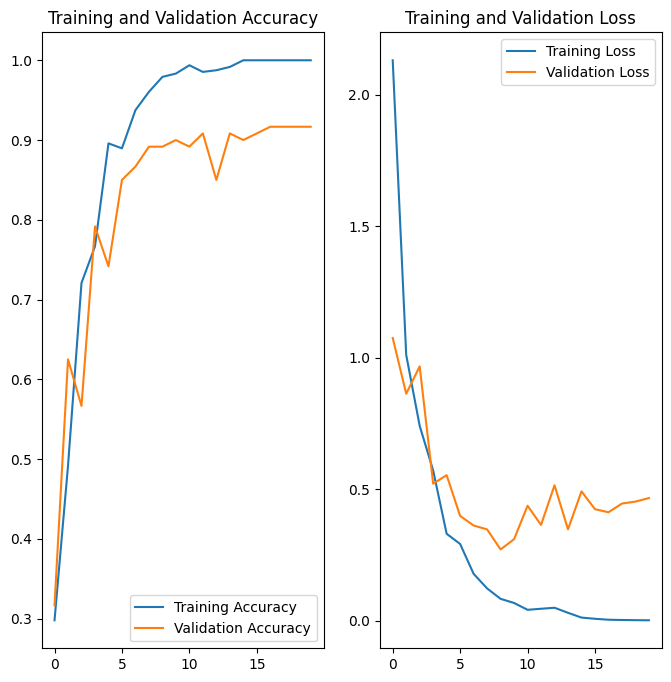

In [21]:
# Extract the training and validation accuracy and loss values from the training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Create a range of epochs for the x-axis
epochs_range = range(epochs)

# Create a figure with two subplots for accuracy and loss visualizations
plt.figure(figsize=(8, 8))

# Subplot 1: Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Subplot 2: Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

# Show the complete figure with both subplots
plt.show()


In [22]:
# Create a data augmentation pipeline using a Keras Sequential model
data_augmentation = keras.Sequential(
  [
    # Randomly flip images horizontally
    layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    
    # Randomly rotate images by a maximum of 0.1 radians
    layers.RandomRotation(0.1),
    
    # Randomly zoom images in or out by a maximum of 0.1 times
    layers.RandomZoom(0.1),
  ]
)


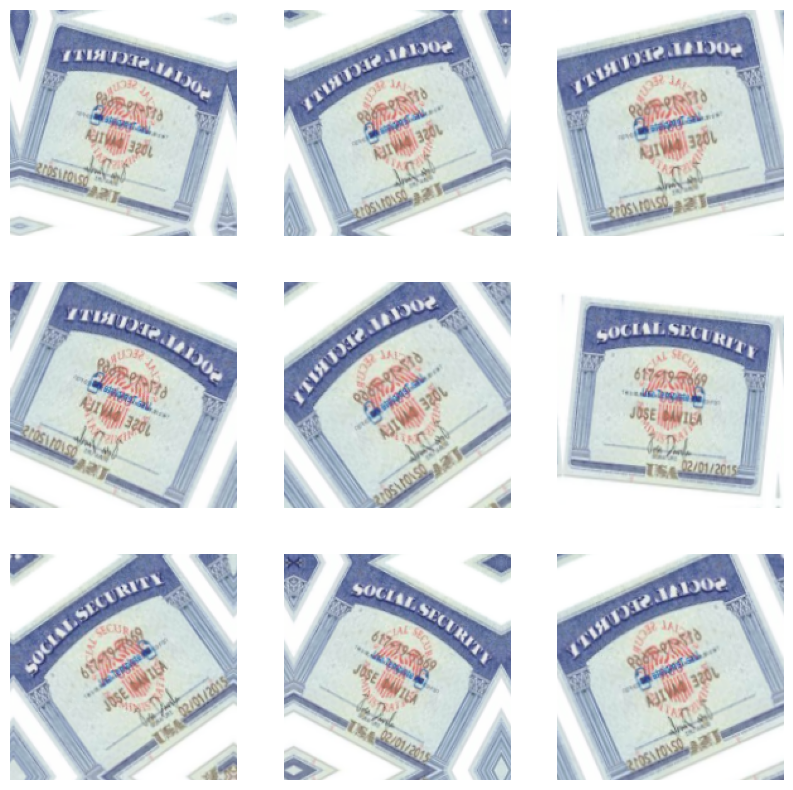

In [23]:
# Create a figure for visualizing augmented images
plt.figure(figsize=(10, 10))

# Loop through the first batch of images from the training dataset
for images, _ in train_ds.take(1):
    # Iterate through the first 9 images
    for i in range(9):
        # Apply data augmentation to the images in the batch
        augmented_images = data_augmentation(images)
        
        # Create a subplot within the 3x3 grid
        ax = plt.subplot(3, 3, i + 1)
        
        # Display the augmented image as a plot and convert it to uint8 format
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        
        # Turn off the axis to remove axis labels
        plt.axis("off")


In [24]:
# Create a Sequential model for image classification with data augmentation
model = Sequential([
  # Data augmentation pipeline defined earlier
  data_augmentation,
  
  # Rescale the input image pixel values to the [0, 1] range
  layers.Rescaling(1./255),
  
  # Convolutional layer with 16 filters, ReLU activation, and 'same' padding
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  
  # Max-pooling layer to downsample the feature maps
  layers.MaxPooling2D(),
  
  # Convolutional layer with 32 filters, ReLU activation, and 'same' padding
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  
  # Max-pooling layer to downsample the feature maps
  layers.MaxPooling2D(),
  
  # Convolutional layer with 64 filters, ReLU activation, and 'same' padding
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  
  # Max-pooling layer to downsample the feature maps
  layers.MaxPooling2D(),
  
  # Dropout layer to prevent overfitting
  layers.Dropout(0.2),
  
  # Flatten layer to convert 2D feature maps to a 1D vector
  layers.Flatten(),
  
  # Fully connected dense layer with 128 units and ReLU activation
  layers.Dense(128, activation='relu'),
  
  # Output layer with units equal to the number of classes
  layers.Dense(num_classes)
])


In [25]:
# Compile the Keras model with the optimizer, loss function, and metrics
model.compile(
    optimizer='adam',  # Use the Adam optimizer for training
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),  # Specify the loss function
    metrics=['accuracy']  # Monitor accuracy as a metric during training
)


In [26]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [27]:
# Set the number of training epochs
epochs = 30

# Train the model using the training dataset and validate using the validation dataset
history = model.fit(
    train_ds,  # Training dataset
    validation_data=val_ds,  # Validation dataset
    epochs=epochs  # Number of training epochs
)

Epoch 1/30
15/15 [==============================] - 7s 406ms/step - loss: 1.3788 - accuracy: 0.3917 - val_loss: 1.0548 - val_accuracy: 0.4250
Epoch 2/30
15/15 [==============================] - 7s 437ms/step - loss: 0.8888 - accuracy: 0.6292 - val_loss: 0.9555 - val_accuracy: 0.5083
Epoch 3/30
15/15 [==============================] - 7s 435ms/step - loss: 0.6528 - accuracy: 0.7271 - val_loss: 0.5617 - val_accuracy: 0.7750
Epoch 4/30
15/15 [==============================] - 6s 401ms/step - loss: 0.5696 - accuracy: 0.7500 - val_loss: 0.4477 - val_accuracy: 0.8583
Epoch 5/30
15/15 [==============================] - 6s 398ms/step - loss: 0.4843 - accuracy: 0.8062 - val_loss: 1.0022 - val_accuracy: 0.6833
Epoch 6/30
15/15 [==============================] - 6s 396ms/step - loss: 0.4082 - accuracy: 0.8521 - val_loss: 0.4662 - val_accuracy: 0.7833
Epoch 7/30
15/15 [==============================] - 6s 398ms/step - loss: 0.3060 - accuracy: 0.8854 - val_loss: 0.5292 - val_accuracy: 0.7917
Epoch 

In [28]:
model.save("cnn-model.h5")

In [29]:
model = tf.keras.models.load_model("output/cnn-model.h5")

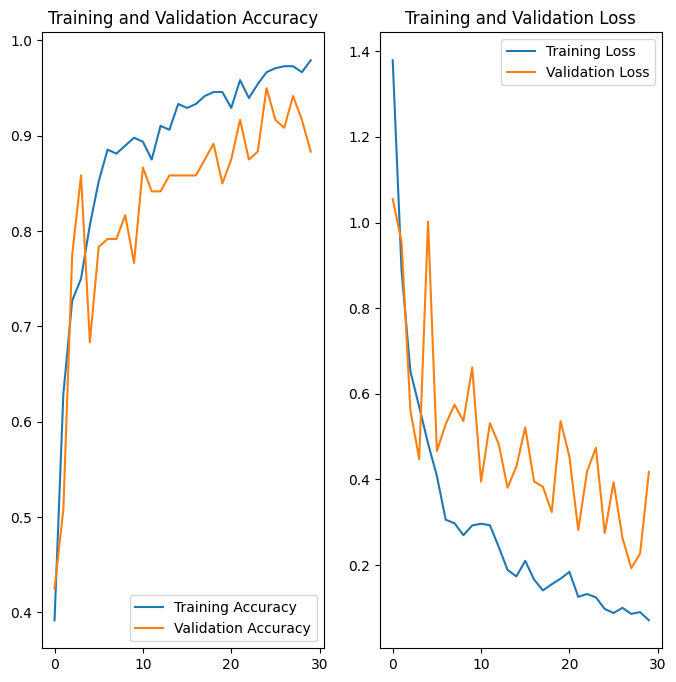

In [31]:
# Extract the training and validation accuracy and loss values from the training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Create a range of epochs for the x-axis
epochs_range = range(epochs)

# Create a figure with two subplots for accuracy and loss visualizations
plt.figure(figsize=(8, 8))

# Subplot 1: Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Subplot 2: Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

# Show the complete figure with both subplots
plt.show()


---

## Prediction

In [32]:
# Path for testing data
test_data_dir = pathlib.Path("input/Testing_Data//")

In [33]:
# Counting number of images in testing data
image_count = len(list(test_data_dir.glob('*/*')))
print(image_count)

150


In [34]:
# Create lists of image file paths for different classes in the test dataset
test_driving_license = list(test_data_dir.glob('driving_license/*'))
test_social_security = list(test_data_dir.glob('social_security/*'))
test_others = list(test_data_dir.glob('others/*'))


In [35]:
# Create a TensorFlow dataset for the test data by loading images from the specified directory
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_data_dir,  # Directory containing test images
  seed=123,  # Seed for reproducibility
  image_size=(img_height, img_width),  # Desired image size
  batch_size=batch_size  # Batch size for the dataset
)


Found 150 files belonging to 3 classes.


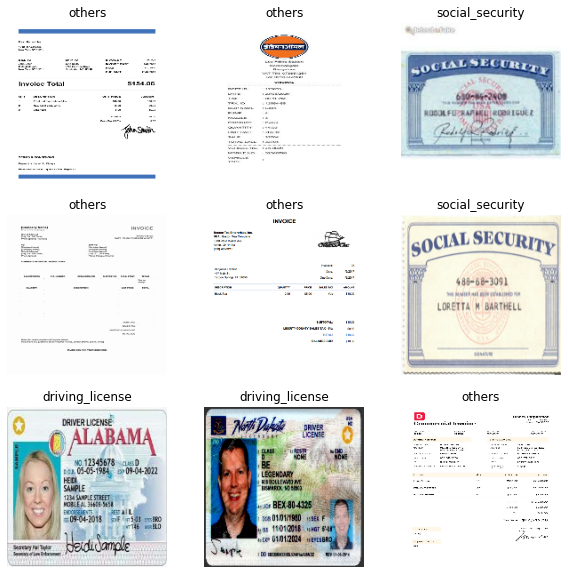

In [36]:
import matplotlib.pyplot as plt

# Create a figure to display test images and their labels
plt.figure(figsize=(10, 10))

# Loop through the first batch of test images and labels
for images, labels in test_ds.take(1):
    # Iterate through the first 9 images
    for i in range(9):
        # Create a subplot within a 3x3 grid
        ax = plt.subplot(3, 3, i + 1)
        
        # Display the test image as a plot and convert it to uint8 format
        plt.imshow(images[i].numpy().astype("uint8"))
        
        # Set the title of the subplot to the corresponding class label
        plt.title(class_names[labels[i]])
        
        # Turn off the axis to remove axis labels
        plt.axis("off")


In [36]:
model.evaluate(test_ds)

2024-11-04 00:12:03.296111: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


5/5 [==============================] - 1s 103ms/step - loss: 1.0168 - accuracy: 0.3467


[1.0167529582977295, 0.3466666638851166]

In [37]:
# Load an image from the specified path and resize it to the target size
img = tf.keras.utils.load_img(
    "input/Testing_Data/others/111.jpg", target_size=(img_height, img_width)
)

# Convert the image to a NumPy array
img_array = tf.keras.utils.img_to_array(img)

# Expand the dimensions of the array to create a batch
img_array = tf.expand_dims(img_array, 0)


In [38]:
# Make predictions on the input image using the trained model
predictions = model.predict(img_array)

# Apply the softmax function to the prediction scores
score = tf.nn.softmax(predictions[0])

# Print the predicted class label and confidence score
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)


This image most likely belongs to social_security with a 39.27 percent confidence.


---